In [85]:
import os

from torchvision import models, transforms
import torch

from PIL import Image

In [86]:
resnet = models.resnet101(pretrained=True)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [87]:
transform = transforms.Compose([            #[1]
    transforms.Resize(256),                    #[2]
    transforms.CenterCrop(224),                #[3]
    transforms.ToTensor(),                     #[4]
    transforms.Normalize(                      #[5]
        mean=[0.485, 0.456, 0.406],                #[6]
        std=[0.229, 0.224, 0.225]                  #[7]
    )])

In [88]:
def preprocess(img):
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    return batch_t

In [89]:
def get_predictions(out):
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    _, indices = torch.sort(out, descending=True)
    return [(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

In [90]:
with open('/mnt/sdb/sihao/imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]
labels = []
for class_ in classes[4:]:
    labels.append(class_.split(", ")[-1])

In [91]:
input_folder = "/mnt/sdb/sihao/ExDark/Motorbike/"
input_paths = [os.path.join(input_folder, path) for path in os.listdir(input_folder)]

In [92]:
input_path = input_paths[0]
input_path = '/home/shchen/Pytorch-UNet/data/test_data/test_data-without_GT/VV/test3453.jpg'
output_path = '/home/shchen/temp/generated.png'

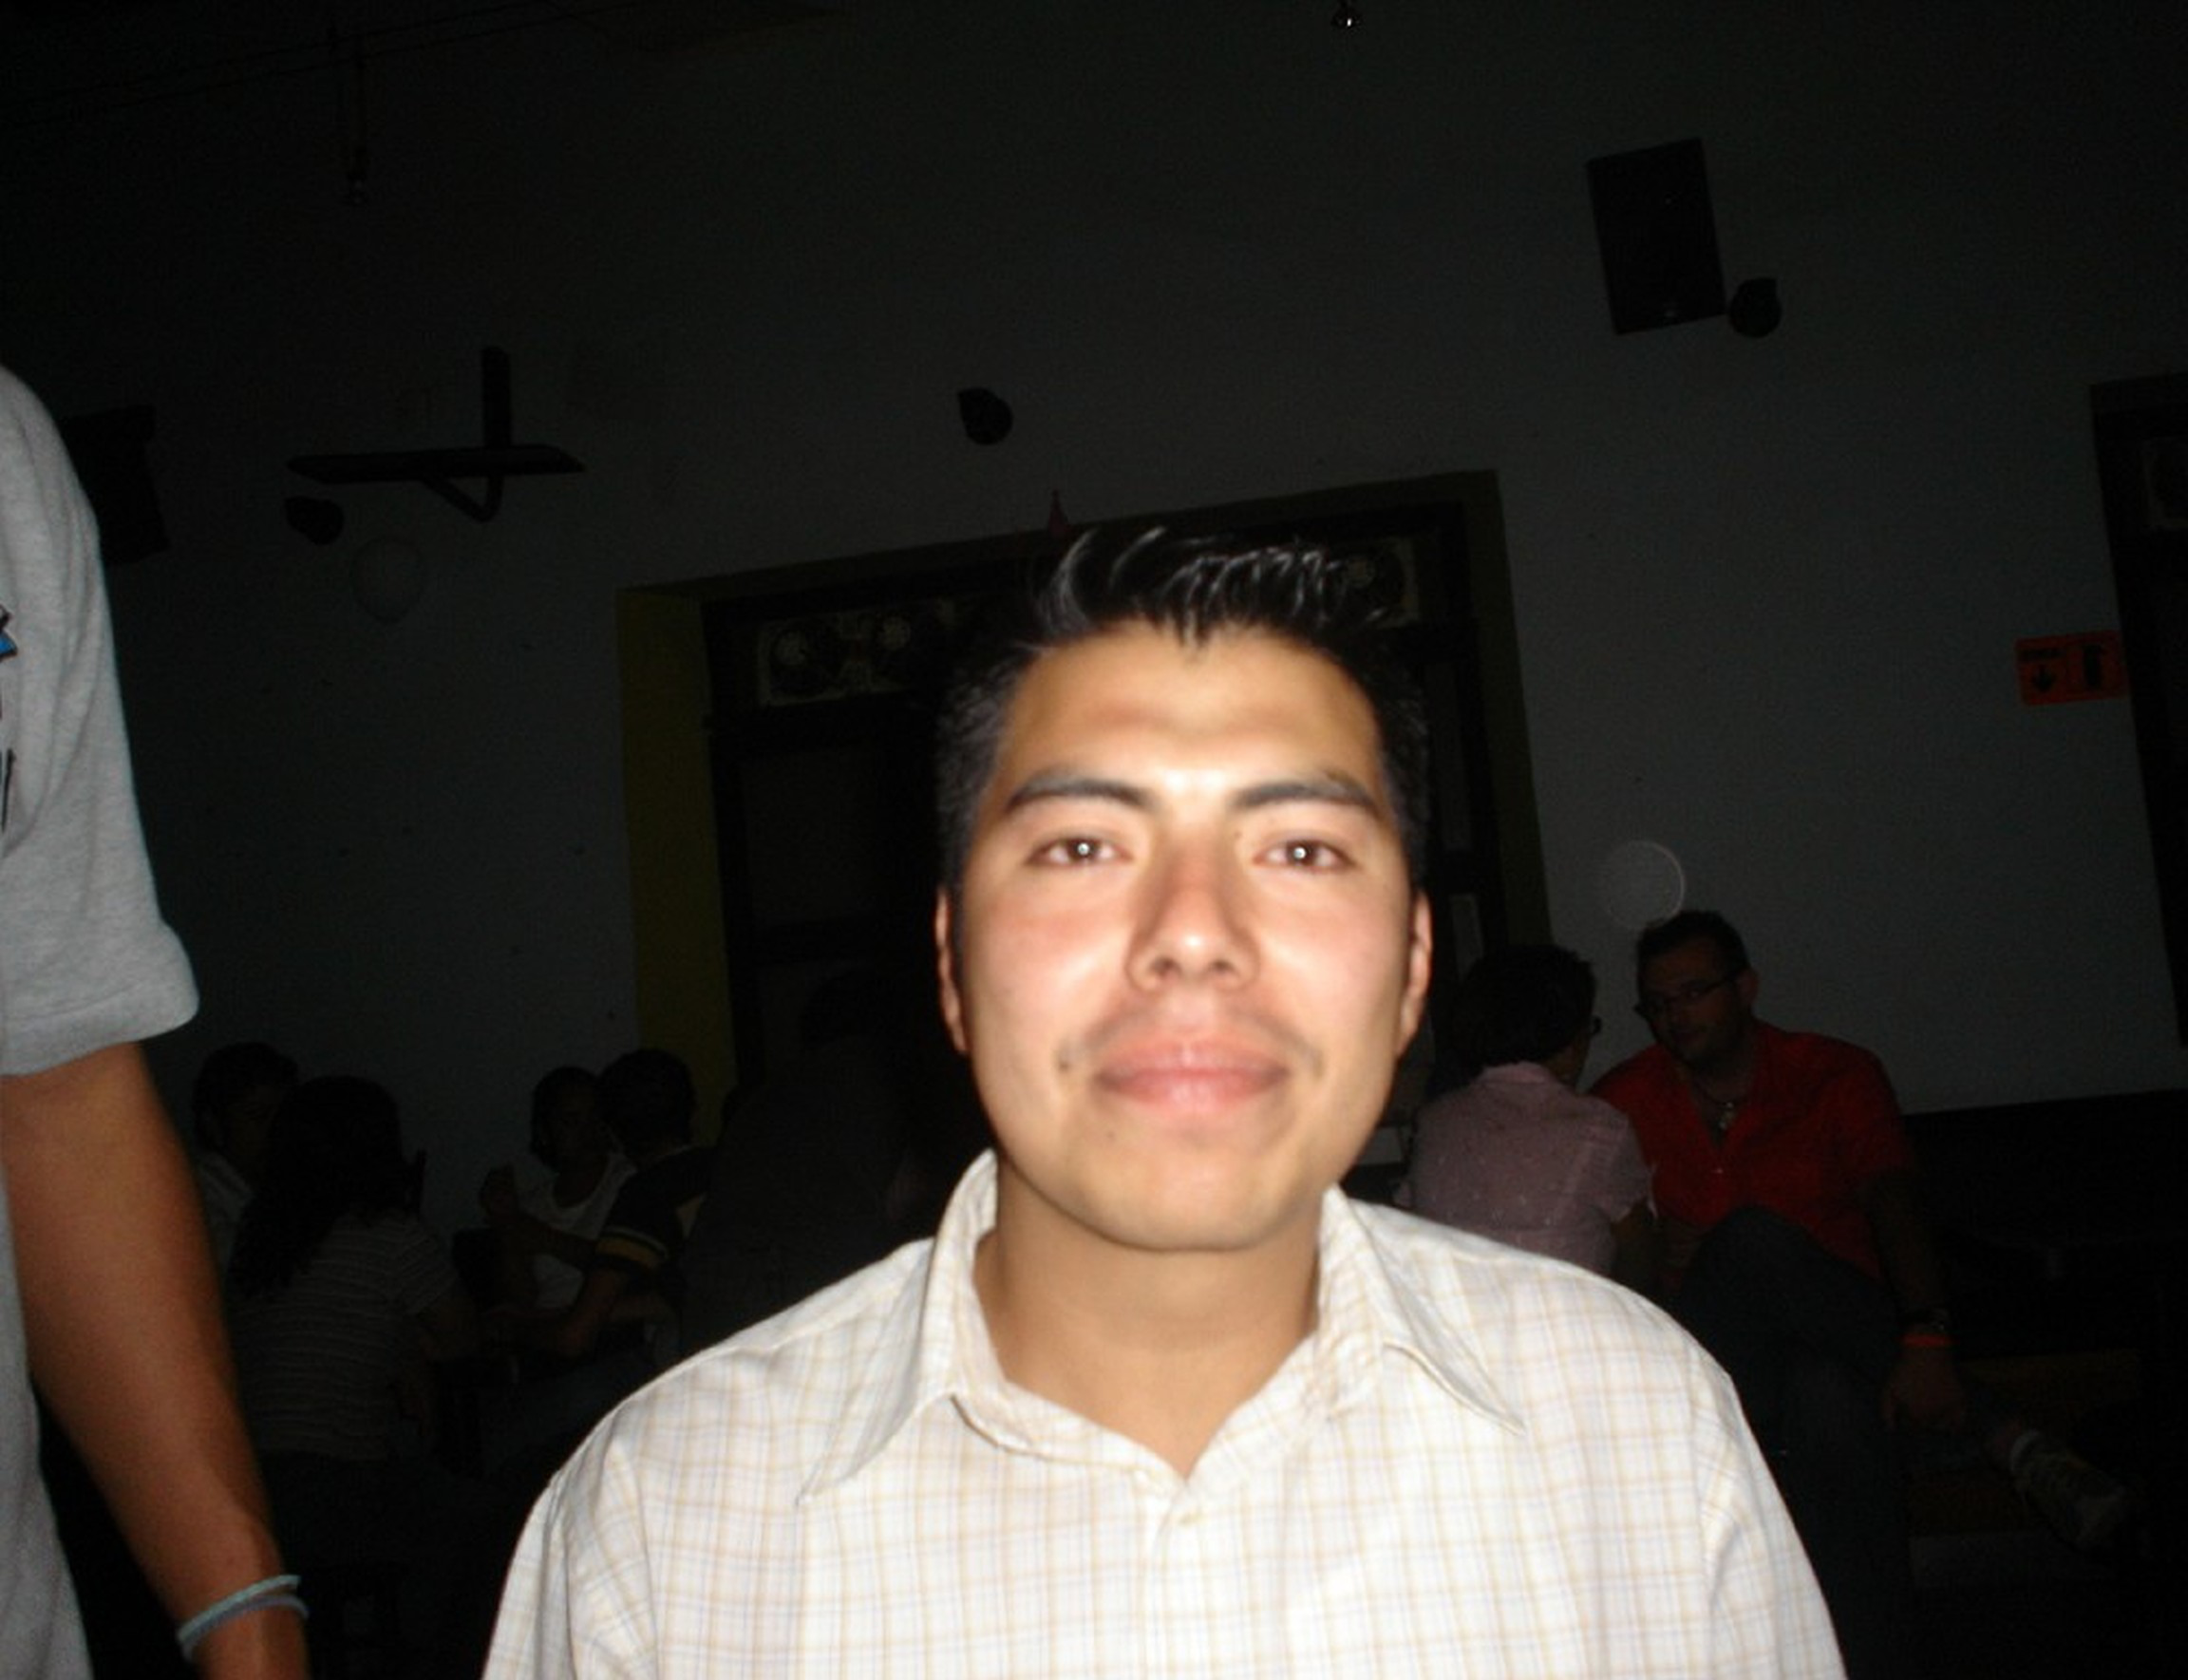

In [82]:
img = Image.open(input_path)
display(img)

In [83]:
!python predict.py -i $input_path -o $output_path -m checkpoints/final_model_noise.pth

INFO:root:Loading model checkpoints/final_model_noise.pth
INFO:root:Using device cuda
INFO:root:Model loaded !
INFO:root:
Generating image /home/shchen/Pytorch-UNet/data/test_data/test_data-without_GT/VV/test3453.jpg ...
INFO:root:target saved to /home/shchen/temp/generated.png


In [84]:
out_img = Image.open(output_path)
display(out_img)

In [204]:
out = resnet(preprocess(img))
get_predictions(out)

[('caldron', 19.851953506469727),
 ('consomme', 15.394316673278809),
 ('ladle', 12.71546745300293),
 ('red_wine', 8.774169921875),
 ('chocolate_sauce', 8.699299812316895)]

In [205]:
out = resnet(preprocess(out_img))
get_predictions(out)

[('consomme', 36.77508544921875),
 ('candle', 10.325464248657227),
 ('soup_bowl', 9.255396842956543),
 ('red_wine', 8.910696029663086),
 ('ladle', 6.157736778259277)]

In [227]:
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = '/home/shchen/ssd/checkpoint_ssd300.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.
    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("./calibril.ttf", 15)

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image

ModuleNotFoundError: No module named 'model'

In [ ]:

if __name__ == '__main__':
    img_path = '/media/ssd/ssd data/VOC2007/JPEGImages/000001.jpg'
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200).show()